# Internet traffic attack recognition (ShieldNet - multiclass)

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
if not torch.cuda.is_available():
    quit()
else:
    print("Cuda capable device found!")

Cuda capable device found!


# Get the datasets from memory

Assumption: dataset has its colums' names stripped from white spaces, no NaNs or +-Inf

In [11]:
ds_selector='.\\datasets\\CICDDoS2019\\CORRECT_CUT\\fair_cut.csv'

In [12]:
df = pd.read_csv(ds_selector)
print("Original length of df:", len(df))

Original length of df: 1352772


## Tidy up the dataset

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352772 entries, 0 to 1352771
Data columns (total 80 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Destination Port             1352772 non-null  int64  
 1   Flow Duration                1352772 non-null  int64  
 2   Total Fwd Packets            1352772 non-null  int64  
 3   Total Backward Packets       1352772 non-null  int64  
 4   Total Length of Fwd Packets  1352772 non-null  float64
 5   Total Length of Bwd Packets  1352772 non-null  float64
 6   Fwd Packet Length Max        1352772 non-null  float64
 7   Fwd Packet Length Min        1352772 non-null  float64
 8   Fwd Packet Length Mean       1352772 non-null  float64
 9   Fwd Packet Length Std        1352772 non-null  float64
 10  Bwd Packet Length Max        1352772 non-null  float64
 11  Bwd Packet Length Min        1352772 non-null  float64
 12  Bwd Packet Length Mean       1352772 non-n

In [15]:
df.drop_duplicates(keep='first', inplace=True)
print('After dropping duplicates:', len(df))

After dropping duplicates: 1278859


In [16]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        print('Removing column', str(col))
        df.drop(col,inplace=True,axis=1)

Removing column Bwd PSH Flags
Removing column Fwd URG Flags
Removing column Bwd URG Flags
Removing column FIN Flag Count
Removing column PSH Flag Count
Removing column ECE Flag Count
Removing column Fwd Avg Bytes/Bulk
Removing column Fwd Avg Packets/Bulk
Removing column Fwd Avg Bulk Rate
Removing column Bwd Avg Bytes/Bulk
Removing column Bwd Avg Packets/Bulk
Removing column Bwd Avg Bulk Rate


In [17]:
df.Label.value_counts()

NTP        112698
MSSQL      112674
UDP        111624
SSDP       111555
SNMP       108894
TFTP       108600
DNS        107416
LDAP       105782
NetBIOS    103143
Syn        102138
BENIGN      99812
UDPLag      94523
Name: Label, dtype: int64

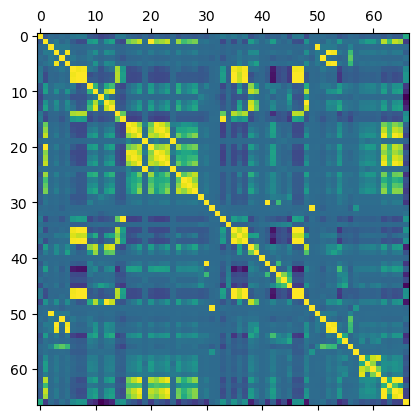

In [19]:
corr_mat=df.corr(numeric_only=True)
plt.matshow(corr_mat)
plt.show()

## Getting ready for learning

In [20]:
cols=df.columns.to_list()
print(cols)
print(len(cols))

['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Le

In [22]:
for i in range(len(df.columns)):
    if cols[i] != 'Label':
        print(i, cols[i], ', Std:', df.iloc[:,i].std(), ', Avg:', df.iloc[:,i].mean())

0 Destination Port , Std: 20028.784104547056 , Avg: 31182.820517351796
1 Flow Duration , Std: 11925671.803274622 , Avg: 2185013.2836880377
2 Total Fwd Packets , Std: 228.33108707988004 , Avg: 9.187896398273773
3 Total Backward Packets , Std: 32.75806122215755 , Avg: 0.8140271914261071
4 Total Length of Fwd Packets , Std: 19995.159543505062 , Avg: 3843.2439197753624
5 Total Length of Bwd Packets , Std: 61804.57507894262 , Avg: 551.51790619607
6 Fwd Packet Length Max , Std: 536.3374140934376 , Avg: 594.347194647729
7 Fwd Packet Length Min , Std: 538.982639083797 , Avg: 569.7901785888828
8 Fwd Packet Length Mean , Std: 532.7087894322 , Avg: 581.0747766662979
9 Fwd Packet Length Std , Std: 43.0225851637282 , Avg: 8.855157438398962
10 Bwd Packet Length Max , Std: 287.9607399810314 , Avg: 26.960953474933515
11 Bwd Packet Length Min , Std: 19.46802696118166 , Avg: 2.969249932948042
12 Bwd Packet Length Mean , Std: 74.2106651340656 , Avg: 8.799390700745406
13 Bwd Packet Length Std , Std: 75.42

In [24]:
%store -r classes_distr_postcut
classes_ids={}
classes_ids=classes_ids.fromkeys(classes_distr_postcut)

one_hot_encoding=torch.nn.functional.one_hot(torch.arange(0,len(classes_distr_postcut)),num_classes=len(classes_distr_postcut))
one_hot_encoding

for idx,(k,_) in enumerate(classes_ids.items()):
    classes_ids[k]=(idx,one_hot_encoding[idx])

classes_ids

{'BENIGN': (0, tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'DNS': (1, tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'LDAP': (2, tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
 'MSSQL': (3, tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])),
 'NetBIOS': (4, tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])),
 'NTP': (5, tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])),
 'SNMP': (6, tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])),
 'SSDP': (7, tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])),
 'Syn': (8, tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])),
 'TFTP': (9, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])),
 'UDP': (10, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])),
 'UDPLag': (11, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))}

In [25]:
replacement_dict={}
replacement_dict_cass_to_id={}
replacement_dict.fromkeys(classes_ids)
for k,(idx, tensor) in classes_ids.items():
    replacement_dict[idx]=tensor
    replacement_dict_cass_to_id[k]=idx

replacement_dict

{0: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 1: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 2: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 3: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 4: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 5: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 6: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 7: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 8: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 9: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 10: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 11: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [26]:
replacement_dict_cass_to_id

{'BENIGN': 0,
 'DNS': 1,
 'LDAP': 2,
 'MSSQL': 3,
 'NetBIOS': 4,
 'NTP': 5,
 'SNMP': 6,
 'SSDP': 7,
 'Syn': 8,
 'TFTP': 9,
 'UDP': 10,
 'UDPLag': 11}

In [27]:
df.replace({'Label':replacement_dict_cass_to_id}, inplace=True)
X=df.iloc[:,:67]
Y=df.iloc[:,67]

In [28]:
tot_col=df.columns.tolist()
tot_col=[(idx,x) for idx,x in enumerate(tot_col)]
tot_col

[(0, 'Destination Port'),
 (1, 'Flow Duration'),
 (2, 'Total Fwd Packets'),
 (3, 'Total Backward Packets'),
 (4, 'Total Length of Fwd Packets'),
 (5, 'Total Length of Bwd Packets'),
 (6, 'Fwd Packet Length Max'),
 (7, 'Fwd Packet Length Min'),
 (8, 'Fwd Packet Length Mean'),
 (9, 'Fwd Packet Length Std'),
 (10, 'Bwd Packet Length Max'),
 (11, 'Bwd Packet Length Min'),
 (12, 'Bwd Packet Length Mean'),
 (13, 'Bwd Packet Length Std'),
 (14, 'Flow Bytes/s'),
 (15, 'Flow Packets/s'),
 (16, 'Flow IAT Mean'),
 (17, 'Flow IAT Std'),
 (18, 'Flow IAT Max'),
 (19, 'Flow IAT Min'),
 (20, 'Fwd IAT Total'),
 (21, 'Fwd IAT Mean'),
 (22, 'Fwd IAT Std'),
 (23, 'Fwd IAT Max'),
 (24, 'Fwd IAT Min'),
 (25, 'Bwd IAT Total'),
 (26, 'Bwd IAT Mean'),
 (27, 'Bwd IAT Std'),
 (28, 'Bwd IAT Max'),
 (29, 'Bwd IAT Min'),
 (30, 'Fwd PSH Flags'),
 (31, 'Fwd Header Length'),
 (32, 'Bwd Header Length'),
 (33, 'Fwd Packets/s'),
 (34, 'Bwd Packets/s'),
 (35, 'Min Packet Length'),
 (36, 'Max Packet Length'),
 (37, 'Packet

In [29]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, Y, shuffle=True, train_size=0.75)
del df,X,Y

f:\miniconda\envs\dl\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [30]:
from sklearn.preprocessing import StandardScaler
scalerX_train = StandardScaler()
X_scaled_train=scalerX_train.fit_transform(trainX)

In [31]:
from torch import tensor
from torch.utils.data import Dataset, DataLoader

class NetMetrics(Dataset):
    def __init__(self, X, y, one_hot):
        self.x, self.y, self.one_hot = X, y, one_hot
        self.len=self.x.shape[0]

    def __getitem__(self,index):
        tensor_label=one_hot_encoding[self.y.iloc[index]]
        return tensor(self.x[index,:], dtype=torch.float32), tensor_label.float()
        
    def __len__(self):
        return self.len

ds=NetMetrics(X_scaled_train, trainY, replacement_dict)

## The model

In [41]:
class AttackNet(torch.nn.Module):
    def __init__(self):
        super(AttackNet, self).__init__()
        self.struct=torch.nn.Sequential(
        torch.nn.Linear(67, 128),
        torch.nn.Tanh(),
        torch.nn.Linear(128, 64),
        torch.nn.Tanh(),
        torch.nn.Linear(64, 64),
        torch.nn.Tanh(),
        torch.nn.Linear(64, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 16),
        torch.nn.Tanh(),
        torch.nn.Linear(16, 12),
        torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.struct(x)

In [42]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Training

Epoch begin:  0
Running loss: 3288.076962977648
Epoch begin:  1
Running loss: 2744.075315952301
Epoch begin:  2
Running loss: 2660.2994823157787
Epoch begin:  3
Running loss: 2612.63753464818
Epoch begin:  4
Running loss: 2610.5180293023586
Epoch begin:  5
Running loss: 2585.6153201162815
Epoch begin:  6
Running loss: 2558.9001091718674
Epoch begin:  7
Running loss: 2550.714768320322
Epoch begin:  8
Running loss: 2547.08267223835
Epoch begin:  9
Running loss: 2561.5516464710236


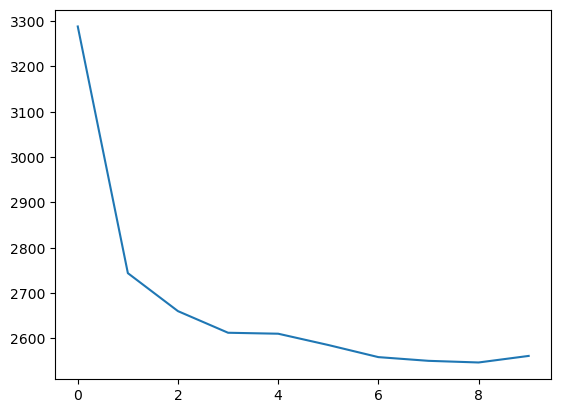

In [43]:
from matplotlib import pyplot as plt

epochs=10
learning_rate = .001
model = AttackNet().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(dataset=ds, batch_size=200, shuffle=True)

out=[]
for epoch in range(epochs):
    print("Epoch begin: ", epoch)
    cumulative_loss=0.0
    for x,y in loader:
        # reset optimizer
        opt.zero_grad()
        loss = criterion(model(x.to(device)), y.to(device))
        loss.backward()
        opt.step()
        #out.append(loss.item())
        #print(loss.item())
        cumulative_loss+=loss.item()
    print('Running loss:', cumulative_loss)
    out.append(cumulative_loss)
plt.plot(out)
torch.save(model.state_dict(), '.\\models\\multi\\initial.model')
#for p in model.parameters(): print(p)

## Test

In [44]:
test_ds = NetMetrics(testX.to_numpy(), testY, one_hot_encoding)
test_loader=DataLoader(dataset=test_ds, batch_size=1)

acc = tensor([0]*12).to(device)
model.eval()
with torch.no_grad():
    for inputs, classes in test_loader:
        inputs=inputs.to(device)
        classes=classes.to(device)
        output=torch.argmax(model(inputs))
        if output==torch.argmax(classes):
            acc[output]+=1
        #else:
            #print('Input', inputs, 'Ground truth',classes, 'Output predicted',output, 'argmax', torch.argmax(classes))

In [45]:
acc

tensor([ 7253,    15,    14,   631,     0,   215, 25327,     1,  6162,     0,
            0,    33], device='cuda:0')